In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("yelp_analysis").getOrCreate()

In [64]:
yelp_business = spark.read.csv('s3://yelpdataanalysis/yelp_business_medium.csv',header=True,inferSchema=True)
yelp_review = spark.read.csv('s3://yelpdataanalysis/yelp_reviews.csv',header=True,inferSchema=True)

In [17]:
print(yelp_business.printSchema())
print(yelp_review.printSchema())

root
 |-- address: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- is_open: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- state: string (nullable = true)

None
root
 |-- business_id: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- user_id: string (nullable = true)

None


In [18]:
# now see top most reviewed business.
# so take review data which has rating(stars) more than 3

review_star_three = yelp_review.filter('stars >3')
grouped_review = review_star_three.groupby('business_id').count()
review_sort = grouped_review.sort('count',ascending=False)

business_only = yelp_business.select('business_id','name','categories')
review_business_name = business_only.join(review_sort,'business_id','inner')
Top_ten_reviewed_business = review_business_name.limit(15)
print('top most reviewed business')
print(Top_ten_reviewed_business.show())

top most reviewed business
+--------------------+--------------------+--------------------+-----+
|         business_id|                name|          categories|count|
+--------------------+--------------------+--------------------+-----+
|-ElDqujEn1u64ynQr...| McFarling Law Group|Lawyers, Real Est...|    2|
|09p3b5BCSz2FPvgR-...|Sammy's Service C...|Auto Repair, Gas ...|    2|
|12ZCvo5eJShrpxwzv...|       Anna's Linens|Shopping, Arts & ...|    1|
|2qjardgA7iqYsuAs0...|AT&T Authorized R...|IT Services & Com...|    1|
|4WVNsBfTtCzfQhCOD...|PartyZams Singing...|Musicians, Event ...|    2|
|4v6e_afy2uAiQYDq9...|Dentistry At Gree...|Health & Medical,...|    2|
|ASXvXm-_-Tm37diPm...|     Zak's Bike Shop|Hiking, Shopping,...|    3|
|FcRf8dciFsQ9ZUj0B...|    Janicek Mike, MD|Health & Medical,...|    2|
|I3G2JYu61LSCZDs4C...|A Gentle Smile De...|Periodontists, De...|    1|
|Nm-9cOSh9SLT2e4qc...|Accredited Home I...|Home Inspectors, ...|    3|
|R4k7r7XHRavbGGJHN...| Formula One Imports|Auto Cu

In [19]:
#Top 10 category which has most business count

from pyspark.sql.functions import split,explode

category = yelp_business.select('categories')
individual_category = category.select(explode(split('categories', ',')).alias('category'))
grouped_category = individual_category.groupby('category').count()
top_category = grouped_category.sort('count',ascending=False)
print('Top 10 category which has most business count')
print(top_category.show(10,truncate=False))

Top 10 category which has most business count
+----------------------+-----+
|category              |count|
+----------------------+-----+
| 'validated': False   |30162|
| Home Services        |6685 |
| Health & Medical     |4815 |
| Automotive           |4196 |
| Local Services       |3763 |
| Shopping             |3291 |
|Home Services         |2645 |
| Auto Repair          |2224 |
| Professional Services|2178 |
| 'classy': False      |2168 |
+----------------------+-----+
only showing top 10 rows

None


In [20]:
#Top Rating give by User to business

rating = yelp_business.select('stars')
group_rating = rating.groupby('stars').count()
rating_top = group_rating.sort('count',ascending=False)
print('Top Rating give by User to business')
print(rating_top.show(5))

Top Rating give by User to business
+-----+-----+
|stars|count|
+-----+-----+
|  5.0| 9665|
|  3.5| 6002|
|  4.0| 5680|
|  4.5| 5528|
|    1| 4609|
+-----+-----+
only showing top 5 rows

None


In [45]:
# Top Locations who have number of business more in world

locations = yelp_business.select('business_id','city')
review_city = yelp_review.select('business_id')
merge_city = locations.join(review_city,'business_id','inner')
grouped_review_city = merge_city.groupby('city').count()
most_reviewed_city = grouped_review_city.groupby('city').sum()
print('Top Locations who have number of business more in world')
print(most_reviewed_city.sort('sum(count)',ascending=False).show(10))

Top Locations who have number of business more in world
+----------+----------+
|      city|sum(count)|
+----------+----------+
| Las Vegas|      9761|
|   Phoenix|      4546|
|Scottsdale|      1723|
|      Mesa|      1623|
| Henderson|      1462|
|   Gilbert|      1118|
|   Toronto|      1107|
|     Tempe|      1052|
| Charlotte|       992|
|  Chandler|       924|
+----------+----------+
only showing top 10 rows

None


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Get the distribution of the ratings

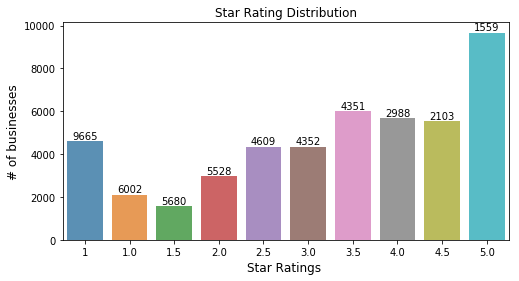

In [60]:
x = yelp_business.groupBy('stars').count().sort('count',ascending=False).toPandas()
#x=df_yelp_bus['stars'].value_counts()
#x=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.iloc[0:10,0], x.iloc[0:10,1], alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.iloc[0:10,1]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### Which city has the more reviews?

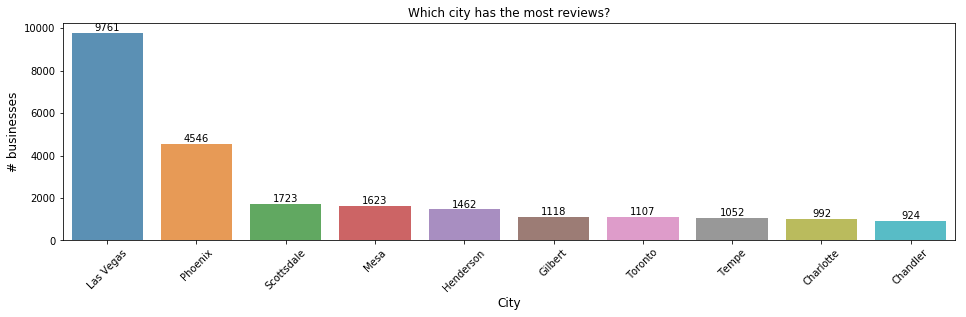

In [61]:
x = most_reviewed_city.sort('sum(count)',ascending=False).toPandas()

plt.figure(figsize=(16,4))
ax = sns.barplot(x.iloc[0:10,0], x.iloc[0:10,1], alpha=0.8)
plt.title("Which city has the most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('City', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.iloc[0:10,1]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### Which category has the most business count?

Text(0.5, 0, 'City')

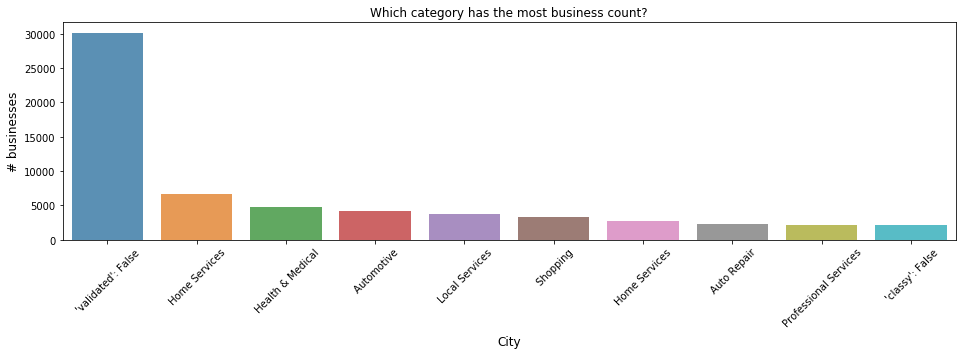

In [62]:
top_cate = top_category.toPandas()

plt.figure(figsize=(16,4))
ax = sns.barplot(top_cate.iloc[0:10,0], top_cate.iloc[0:10,1], alpha=0.8)
plt.title("Which category has the most business count?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('City', fontsize=12)